# Student Decline on the HMH MI/RI

## Background
In the 4 years that City Year Los Angeles (CYLA) has utilized the HMH Math Inventory (MI) and Reading Inventory (RI), it has consistantly been observed that about a third of assessed students will decline from the first to the second assessment. Over the years there has been considerable conversation on what might be the cause of this decline for a seemingly large proportion of served students, and many hypotheses have been proposed related to ACM investment in assessments, student motivation, and variations in environmental conditions and student conditions.  However a lack of evidence for any hypothesis has typically stalled conversations on what the cause of the decline might be, and the site in many ways has shifted more to an acceptance that this will happen. 

However, recent reviews of research conducted by HMH on the MI and RI have begun to offer some clarity on the sources of measurement error for the MI and RI.  This information in turn has enabled us to begin to model what our expectations for 

In this paper we will start by seeking to understand Scholastic's research on the measurement error inherent in both assessments.  We will then consider the implications for a single student and quantify the likelihood that we observe a decline for that student. Finally, we model CYLA's program overall and quantify what our expectations for student decline should be, given the students we have. 

In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

## Measurement Error in the MI/RI
Fundumantal to the problem is that intangible concepts like "reading comprehension" or "mathematical understanding" are hard to measure, because they have to be measured indirectly.  While ideally we would measure reading comprehension like we would a student's height, it's of course much more complicated then that requiring that we find proxies to represent a reasonable approximation of a student's reading comprehension. In the RI we measure a students' responses to questions about a passage of text, and this measurement is further complicated by the interaction of human behavior on top of it all. 

In practical terms, these sources of error cumulate in a measure called the SEM or standard errors of measurement. If a students has a "true" lexile of 700L, then the SEM describes the range in which the RI might measure that students Lexile.  For example, if the SEM were equal to 50 for a student with a lexile of 700L, then we would expect to measure the students Lexile between 650L and 750L two-thirds of the time.  Figure 1 shows the shape of this distribtuion below. 

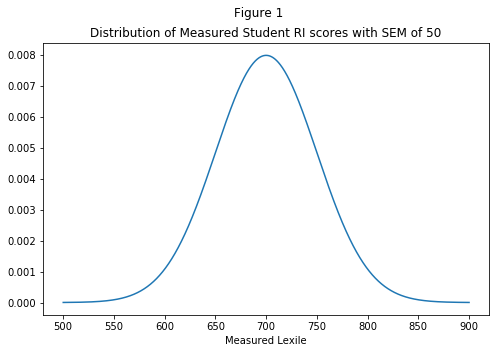

In [12]:
x_axis = np.arange(500, 900, 0.001)
fig = plt.figure(figsize=(8, 5))
fig.suptitle("Figure 1")
ax = fig.add_subplot(111)
ax.plot(x_axis, norm.pdf(x_axis, 700, 50))
ax.set_title("Distribution of Measured Student RI scores with SEM of 50")
ax.set_xlabel("Measured Lexile")
plt.show()

### Standard Errors in Measurement for MI/RI
In a report published by HMH titled *Accuracy Matters: Reducing Measurement Error by Targeted HMH Reading Inventory Testing*, the SEM for the RI is thoroughly explored. The most important factor in reducing the measurement error is the number of questions a student has answered.  Before a student has answered 40 questions, the assessment targets the student primarily by the grade level that student is in.  However, after answering 40 questions the assessment adjusts and now includes the students' reading level in assessing a their Lexile. The SEM for first, second, and third round assessments in the RI are:

|Round|SEM w/o Established Reading Level|SEM w/ Established Reading level|
|:---:|:---:|:---:|
|1|91L|56L|
|2|73L|54L|
|3|56L|52L|

For the MI, HMH has done less in detailing how the SEM will decrease as the system collects more information on a particular students.  However, in their Technical Guide HMH identified the SEM for MI as being 70Q and in a more recent guide on interrpring student declines adjusted the estimate down to 63Q. However, again that SEM is predicated on the student having an established baseline within the system, and thus prior to answering 40 questions we should expect the SEM to be higher.

While for either assessment the SEM will vary from student to student, we will use the values from above in conducting the modeling as they function as a reasonable approximation for setting our expectations in response to measurement error. 

## Decline for a Single Student
Now knowing that Lexile/Quantile measurements are in fact samples from a distribution, there is some question on how this would effect a students measured performance between two administrations of the MI or RI. For concreteness, lets visualize what this situation might look like for a student taking the MI.  Say that we know that their true ability at the baseline is 700Q and that they improved by 50Q from the first administration. This can be visualized as two normal distributions as we see in figure 2 below.  What is key to notice is that because of the error in the measurement, there is a significant area in the graph where they overlap.  That overlap corressponds to scenarios where a student would be measured as declining from the baseline to follow up, even though we *know* that the student actually did improve by 50 points. Based on some simulation data, in this precise case we determined that the probability that a student had a measured decline would be 30%

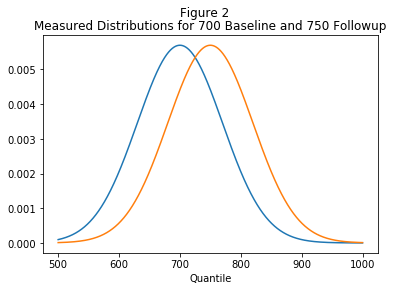

In [8]:
x_axis = np.arange(500, 1000, 0.001)
fig = plt.figure()
fig.suptitle("Figure 2")
ax = fig.add_subplot(111)
ax.plot(x_axis, norm.pdf(x_axis, 700, 70))
ax.plot(x_axis, norm.pdf(x_axis, 750, 70))
ax.set_title("Measured Distributions for 700 Baseline and 750 Followup")
ax.set_xlabel("Quantile")
plt.show()

In [14]:
def decline_likelihood(true_improvement):
    # Hidden Values
    true_baseline = 700
    true_followup = true_baseline + true_improvement
    
    # Model
    with pm.Model() as mi_model:
        baseline = pm.Normal('baseline', true_baseline, sd=70)
        followup = pm.Normal('followup', true_followup, sd=70)
        improvement = pm.Deterministic('improvement', followup - baseline)

        trace = pm.sample(10000, step=pm.Metropolis(), progressbar=False)

    return (trace['improvement'] < 0).mean()

decline_likelihood(50)

0.31850000000000001

### Main Factors in the Probability of Decline
There are two main factors in determining the probability that a student will have a measured decline from baseline to follow up.  
1.  Measurement Error - Scholastic pointed out that the SEM will decline on subsequent assessment, though they couldn't provide concrete numbers on the rate of decline.  However it is important to know that the assessment is more accurate the most score a student has in the system. 
2.  Amount of Improvement - The probability that a decline is measured is inversly proportional to the amount of improvement they truly experienced.

The combination of both of these points begins to get at why we see so many more students decline between the first and second administrations compared to the first and third.  Both is there less error by the third assessment, but the amount of improvement is greater, thus decreasing the probability that a decline is measured.

To give a sense of point 2, we performed a series of simulations to calculate the probability of measured decline for improvements ranging from 0 points to 150 and visualized it in figure 3.  The key takeaway is to notice that when improvement is close to 0, the probability that we measure a decline is close to 50%.  Then, as the amount of improvement increases, it becomes less and less likely that we measure a decline.  However, even when the true improvement is 100 points, there is still a ~18% probability of measuring a decline

In [15]:
improvements = [imp for imp in range(150)]
decline_likes = [decline_likelihood(imp) for imp in range(150)]

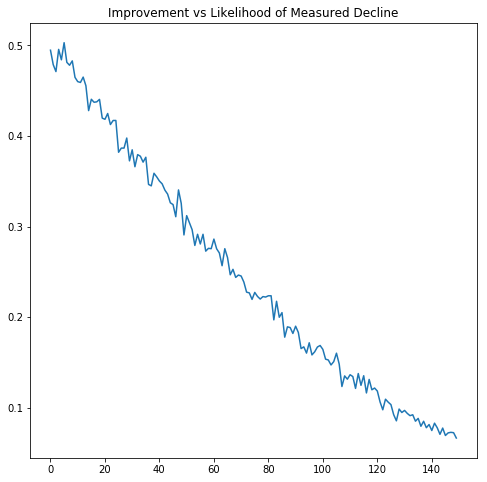

In [18]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.plot(improvements, decline_likes)
ax.set_title("Improvement vs Likelihood of Measured Decline")
plt.show()

## Predicting the Amount of Measured Decline
So far we've constrained our examination to a single student, however we of course assess students with a variety of baseline scores and levels of improvement.  A useful question we might ask would be what percentage of our program should we expect to measure a decline with, given the information we have been given by Scholastic.  To begin to answer these questions I have pulled data from FY17, specifically records for all 6th graders with 3 MI scores.  From those records, we will simulate 10,000 'focus list students' with baselines of approximately the same as our FY17 students and a hidden 'true' improvement value that is drawn from the gamma distribution (see conversation on this choice below).  From these simulations we'll approximate the probability that our focus list caseload overall should decline, at least for 6th graders.

In [40]:
mi_data = pd.read_excel('MI Data.xlsx')
mi_data.describe()

,Baseline,Follow Up 1,Follow Up 2,Imp 1,Imp 2
count,166.000000,166.000000,166.000000,166.000000,166.000000
mean,416.656627,465.271084,533.614458,48.614458,116.957831
std,181.309537,190.893637,221.089332,164.599262,214.747755
min,-55.000000,25.000000,-215.000000,-495.000000,-325.000000
25%,281.250000,325.000000,371.250000,-76.250000,-17.500000
50%,417.500000,450.000000,540.000000,45.000000,107.500000
75%,537.500000,600.000000,688.750000,173.750000,223.750000
max,795.000000,910.000000,1065.000000,395.000000,765.000000


In [41]:
with pm.Model() as first_followup:
    true_baseline = pm.Normal('baseline_mean', 416, sd=181)
    true_improvement = pm.Gamma('true_improvement', mu=50, sd=100)
    
    baseline = pm.Normal('baseline', true_baseline, sd=70)
    followup = pm.Normal('followup', baseline + true_improvement, sd=70)
    improvement = pm.Deterministic('improvement', followup - baseline)

    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 99%|██████████████████████████████████▊| 10435/10500 [00:16<00:00, 622.66it/s]C:\Users\aperusse\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 742 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|███████████████████████████████████| 10500/10500 [00:16<00:00, 622.82it/s]


The following are the samples drawn in our simulation of the first follow up.

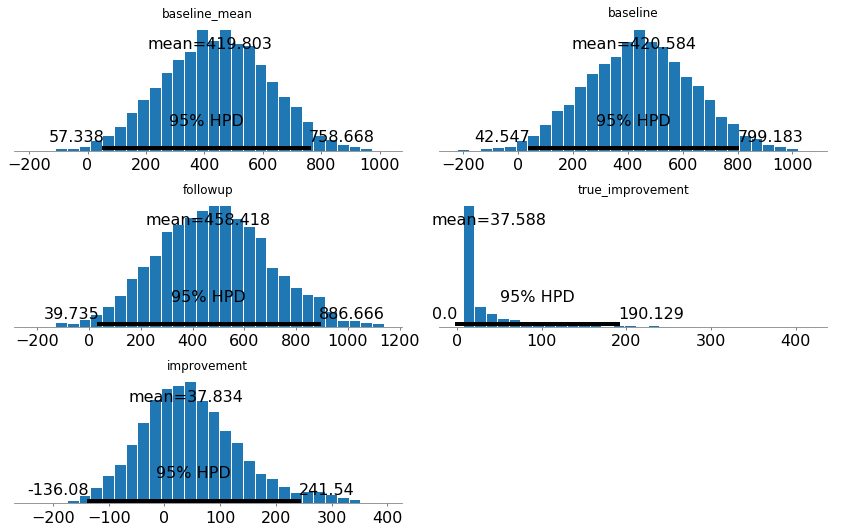

In [43]:
pm.plot_posterior(trace)
plt.show()

In [39]:
(trace['improvement'] < 0).mean()

0.36399999999999999

In [44]:
with pm.Model() as second_followup:
    true_baseline = pm.Normal('baseline_mean', 416, sd=181)
    true_improvement = pm.Gamma('true_improvement', mu=116, sd=100)
    
    baseline = pm.Normal('baseline', true_baseline, sd=70)
    followup = pm.Normal('followup', baseline + true_improvement, sd=70)
    improvement = pm.Deterministic('improvement', followup - baseline)

    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████████████████████████████▉| 10465/10500 [00:16<00:00, 642.06it/s]C:\Users\aperusse\AppData\Local\Continuum\Anaconda3\envs\bayes\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 9 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|███████████████████████████████████| 10500/10500 [00:16<00:00, 641.97it/s]


The following are the samples drawn in our simulation of the progress from baseline to third administration.

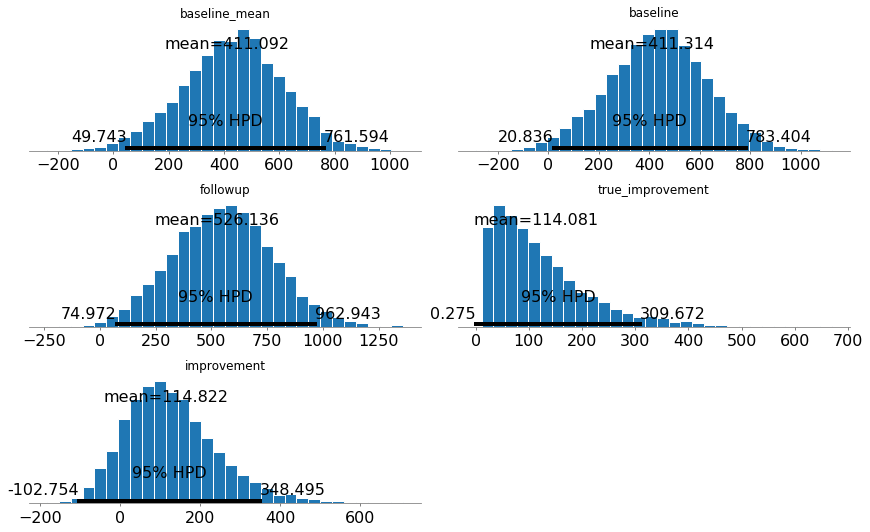

In [45]:
pm.plot_posterior(trace)
plt.show()

In [46]:
(trace['improvement'] < 0).mean()

0.151

### Simulation Results
After running the simulation of our program we found that from the baseline to the second administration, we should expect to measure ~36% of our program decreasing.  This, of course, is in spite that our model only allows students to 'truly' improve.  However, when modeling the improvement from first to third administration, we find that the expected decreases goes down to ~15%.